In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import os
import time
from tensorflow.keras.layers import (Dense, 
                                     BatchNormalization, 
                                     LeakyReLU, 
                                     Reshape, 
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)


# example of defining the discriminator model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
from IPython import display

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [5]:
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[20%:]'],
    with_info=True,
    as_supervised=True,
)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random

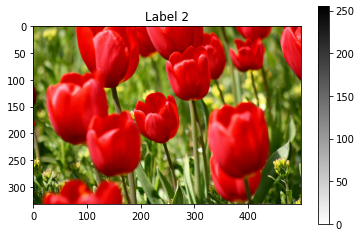

In [7]:
for image, label in training_set.take(1):
    break
image = image.numpy()
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.title('Label {}'.format(label))
plt.colorbar()
plt.grid(False)
plt.show()

In [8]:
IMG_SIZE = 64
  
def format_image(image, label):
  
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = ( image - 127.5 ) / 127.5
    image = tf.image.random_flip_left_right(image)

    return image



#ساخت یک تنسرفلو دیتاست که در بچ های 128تایی دیتا را لود کرده و بل بافر سایز 300 تایی عملیات بهمریختن عکس ها را انجام دهد
BATCH_SIZE = 128
training_set = training_set.shuffle(300).map(
    format_image).batch(BATCH_SIZE)
validation_set = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

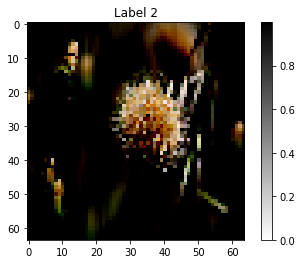

In [9]:
for image in training_set.take(1):
    break
image = image.numpy()
plt.figure()
plt.imshow(image[1], cmap=plt.cm.binary)
plt.title('Label {}'.format(label))
plt.colorbar()
plt.grid(False)
plt.show()

In [10]:
print(training_set)
print(validation_set)

<BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>
<PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>


In [11]:
for x in training_set.take(1):
  print(x)

tf.Tensor(
[[[[-6.98897064e-01 -5.98529398e-01 -1.00000000e+00]
   [-6.84926450e-01 -5.81372559e-01 -9.43750024e-01]
   [-6.91176474e-01 -6.14338219e-01 -1.00000000e+00]
   ...
   [-6.97426498e-01 -6.20588243e-01 -1.00000000e+00]
   [-6.64705873e-01 -5.92524529e-01 -9.49999988e-01]
   [-7.28676498e-01 -6.34558797e-01 -1.00000000e+00]]

  [[-7.65318632e-01 -6.63357854e-01 -1.00000000e+00]
   [-2.45098040e-01 -7.73284286e-02 -8.18627477e-01]
   [-2.84681380e-01 -6.94852918e-02 -9.23406839e-01]
   ...
   [-2.87745088e-01 -8.38235319e-02 -9.32598054e-01]
   [-2.32107848e-01 -8.61519575e-02 -8.28799009e-01]
   [-7.15563715e-01 -6.04044139e-01 -1.00000000e+00]]

  [[-7.56985307e-01 -6.86397076e-01 -1.00000000e+00]
   [ 2.02205889e-02 -3.30882357e-03  1.30024508e-01]
   [-9.65808809e-01 -9.34313715e-01 -9.98897076e-01]
   ...
   [-8.63602936e-01 -8.78921568e-01 -9.99632359e-01]
   [-8.16176459e-02 -8.16176459e-02 -3.18627455e-03]
   [-7.09926486e-01 -6.62867665e-01 -9.45220590e-01]]

  ...

 

In [12]:
 # شبکه جنریتور که با مفهوم سکوئنشیال در تنسرفلو پیاده سازی شده است.  این شبکه از لایه های آپ سمپلینگ برای تولید عکس از یک رندوم نویز استفاده می کند. این رندوم نویز با اندازه 100 و در لایه دنس اول وارد شبکه می شود و ابعاد نویز را پس از چندبار اعمال لایه آپ سمپلینگ به ابعاد تصویر مورد نظر که 64 در 64 است می رساند


def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(4*4*512, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((4, 4, 512)))

    model.add(Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())


    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [13]:
generator = make_generator_model()

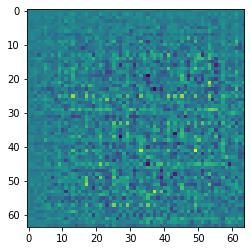

In [14]:
#استفاده از شبکه جنریتور که هنوز ترین نشده برای تولید یک عکس
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [15]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

In [16]:
generated_image[0, :, :, 1]

<tf.Tensor: shape=(64, 64), dtype=float32, numpy=
array([[-1.0444299e-04,  1.2048606e-04,  1.1616500e-04, ...,
        -4.3545858e-04, -2.4050589e-04, -3.6371770e-04],
       [-1.5586258e-04, -7.2582334e-05,  3.1843263e-04, ...,
        -9.8725443e-04,  7.5591140e-04, -9.6536212e-05],
       [-2.5344142e-04, -7.3949515e-04,  7.2349736e-05, ...,
        -2.3674036e-04,  1.7098273e-04,  2.9207824e-04],
       ...,
       [-1.6746098e-04,  1.2230991e-03,  4.8507328e-04, ...,
         1.5519991e-03, -1.0109365e-03,  1.0125603e-03],
       [ 5.8366725e-04, -4.7787512e-04,  7.1690138e-04, ...,
         5.9778267e-04,  1.4074267e-03, -2.9594854e-03],
       [-2.2607228e-04, -1.8535802e-04, -3.4127547e-04, ...,
        -1.5456924e-03,  2.4597156e-03, -4.3678563e-04]], dtype=float32)>

In [17]:
#شبکه متمایز کننده که یک شبکه بر پایه CNN است
#این شبکه از مفهوم شکوئنشیال برای طبقه بندی تصویر به واقعی و غیر واقعی استفاده می کند

def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2DTranspose(1, (4, 4), padding='same', use_bias=False, activation='sigmoid'))


    return model

In [18]:
#استفاده از شبکه متمایز کننده برای طبقه لندب عکس ها به واقعی و غیر واقعی. این شبکه هنوز ترین نشده و پس از آموزش اعداد مثبت را برای تصاویر واقعی و منفی برای غیر واقعی ها بر میگرداند


discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor(
[[[[0.50000626]
   [0.5000464 ]
   [0.50003   ]
   [0.5000084 ]]

  [[0.50001144]
   [0.49999726]
   [0.5000054 ]
   [0.50000095]]

  [[0.5000275 ]
   [0.4999951 ]
   [0.5000042 ]
   [0.5000428 ]]

  [[0.49999547]
   [0.49999642]
   [0.49998772]
   [0.49999976]]]], shape=(1, 4, 4, 1), dtype=float32)


In [19]:

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#تابع ضرر مربوط به متمایز کننده .که میزان خطای متمایز کننده در تشخیص تصاویر واقعی و فیک را کمی می کند. 
#این تابع تصاویر واقعی را با آرایه ای از 1 ها و تصاویر جعلی را با آرایه ای از ضفر ها مقایسه می کند
#ضرر نهایی جمع ضرر ها روی تصاویر واقعی و جعلی است



def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#تابع ضرر جنریتور برای مشخص کردن اینکه جنریتور چقد تواسنته است متمایز کننده را فریب دهد
#این تابع تصاویر جعلی(تصاویر تولید شده توسط شبکه جنریتور) را با آرایه ای از 1 ها مقایسه می کند یعنی اگر جنراتور بخوبی عمل کند شبکه متمایز کننده تصاویر جعلی را بعنوان واقعی یا با برچسب 1 طبقه بندی می کند 


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#آپتیمایز برای دو شبکه جنریتور و متمایز کننده



generator_optimizer = tf.keras.optimizers.Adam(0.0002)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002)

In [20]:
#استفاده از چک پوینت ها برای سیو کردن مدل در ایپاک های آموزش و آموزش مدل از ایپاک های نهایی آموزش قبل از وقفه های احتمالی
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  checkpoint.restore(ckpt_manager.latest_checkpoint)
  #print (os.path.splitext(file_name)[0],'Latest checkpoint restored!!')

In [21]:
tf.train.latest_checkpoint(
    checkpoint_dir, latest_filename=None
)

'./training_checkpoints/ckpt-669'

In [22]:
#tf.train.latest_checkpoint='./1/training_checkpoints/ckpt-58.index'

In [23]:
tf.train.latest_checkpoint(
    checkpoint_dir, latest_filename=None
)

'./training_checkpoints/ckpt-669'

In [32]:

EPOCHS = 1000
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
num_examples_to_generate = 16
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [25]:
#حلقه آموزش شبکه گن
#شروع با شبکه جنراتور که یک نویز را به عنوان ورودی میگیرد سپس استفاده از شبکه متمایز کننده برای ظبقه بندی تصویر به جعلی و واقعی
#ضرر ها برای هر شبکه محاسبه و گرادیان ها برای به روز رسانی دو شبکه استفاده می شود
#دو شبکه به طور همزمان آموزش داده خواهند شد 
#



# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [26]:
#در هر ایپاک تصاویر به صورت بچ بچ خوانده می شوند
#حلقه آموزش روی هر بچ از تصویر اعمال می شود
#




def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [27]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8, 8))

  for i in range(predictions.shape[0]):
    
      plt.subplot(8, 8, i+1)
      #image = predictions[i, :, :, :]
      #image = image.reshape(predictions.shape[1], predictions.shape[2], predictions.shape[3])
      #plt.imshow((predictions[i] + 1) / 2)
      plt.imshow(predictions[i, :, :,:] * 127.5 + 127.5)
  if epoch%500==0:    
    plt.savefig('./job/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [28]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(20,20))
    for i in range(predictions.shape[0]):
        plt.subplot(6, 8, i+1)
        plt.imshow((predictions[i, :, :, :] * 127.5 + 127.5) / 255.)
        plt.axis('off') 
        
    plt.subplots_adjust(wspace=0, hspace=0)
    if epoch%500==0:
      plt.savefig('./job/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
#در ابتدای آمورش تصاویر تولید شده توسط شبکه جنراتور مانند نویز تصادفی به نظر می رشند و با ادامه ترین مدل گن تصاویر به تصاویر واقعی نزدیک می شوند

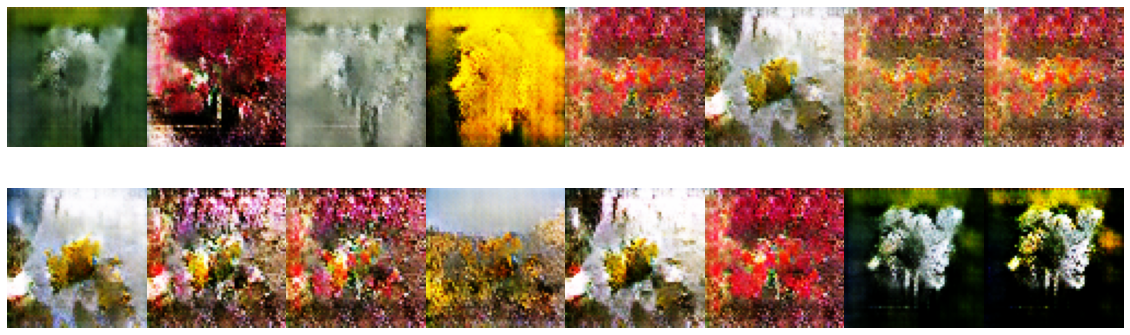

In [33]:
 train(training_set, EPOCHS)

In [37]:
generator.save('./job/generator.h5')

In [38]:
# save model
generator.save_weights('./job/generatorr.h5')
print('Model Saved!')

Model Saved!


In [40]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              819200    
                                                                 
 batch_normalization_5 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 4, 4, 256)        3276800   
 ranspose)                                                       
                                                                 
 batch_normalization_6 (Batc  (None, 4, 4, 256)       